In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns; sns.set()
import calmap

# For accident density plot
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch

In [2]:
%matplotlib inline

In [3]:
df = pd.read_csv("Acc.csv")
df.columns
df.Date = pd.to_datetime(df.Date)

/Users/garfield/Library/Python/3.5/lib/python/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Utitlities

In [4]:
def remap_legend(ax, mapping):
    for t in ax.axes.get_legend().texts:
        t.set_text(mapping[t.get_text()])

# Feature description

The description of each feature can be found in:
http://data.dft.gov.uk/road-accidents-safety-data/Road-Accident-Safety-Data-Guide.xls

Values exported as -1 correspond to NULLs.

Many of the columns contain highly redundant information for example the easting and northing are essentially the same as the latitude and longitude. Another would be `Police Force` with the `Local Authority`.

Also the `Accident_Index` is an arbitrary number without information. It is likely there so that this dataset can be joined with other datasets that are out of the scope of this exercise.

In [5]:
print("Number of entries: {}".format(len(df)))

Number of entries: 129982


## Data Clean Up

In [6]:
df.isnull().sum()

Accident_Index                                    0
Location_Easting_OSGR                            19
Location_Northing_OSGR                           19
Longitude                                        29
Latitude                                         29
Police_Force                                      0
Accident_Severity                                 0
Number_of_Vehicles                                0
Number_of_Casualties                              0
Date                                              0
Day_of_Week                                       0
Time                                              3
Local_Authority_(District)                        0
Local_Authority_(Highway)                         0
1st_Road_Class                                    0
1st_Road_Number                                   0
Road_Type                                         0
Speed_limit                                       0
Junction_Detail                                   0
Junction_Con

We don't have too many NaNs per column so we will just remove those from the data for the time being.

In [7]:
df.dropna(inplace=True)

Next we want to check how many of the other features are missing. According to the supplementary data this are indicated with a `-1`. We only print those that have missing features.

In [8]:
for feature in df:
    n_missing_features = len(df.loc[df[feature] == -1])
    if n_missing_features != 0:
        print(
            "{0}: \t {1}/{2} -> {3}%".format(
            feature,
            n_missing_features,
            len(df),
            str(n_missing_features/len(df)*100)[:4]),
        )

Junction_Detail: 	 609/122838 -> 0.49%
Junction_Control: 	 52853/122838 -> 43.0%
2nd_Road_Class: 	 50903/122838 -> 41.4%
2nd_Road_Number: 	 84/122838 -> 0.06%
Pedestrian_Crossing-Human_Control: 	 2573/122838 -> 2.09%
Pedestrian_Crossing-Physical_Facilities: 	 2764/122838 -> 2.25%
Light_Conditions: 	 1/122838 -> 0.00%
Weather_Conditions: 	 1/122838 -> 0.00%
Road_Surface_Conditions: 	 1934/122838 -> 1.57%
Special_Conditions_at_Site: 	 2205/122838 -> 1.79%
Carriageway_Hazards: 	 2072/122838 -> 1.68%


A few values are missing but except for the the `Pedestrian_Crossing` features the situation is very manageable.

## Add hour columns

In [9]:
df["Time_Hour"] = df.Time.apply(lambda x: int(x[:2]))

# Data Analysis

## Where are accidents happening?

Where should the police force be deployed in order to avoid accidents with fatalities? With the next cell we can filter out accidents by region and plot them based on their coordinates.

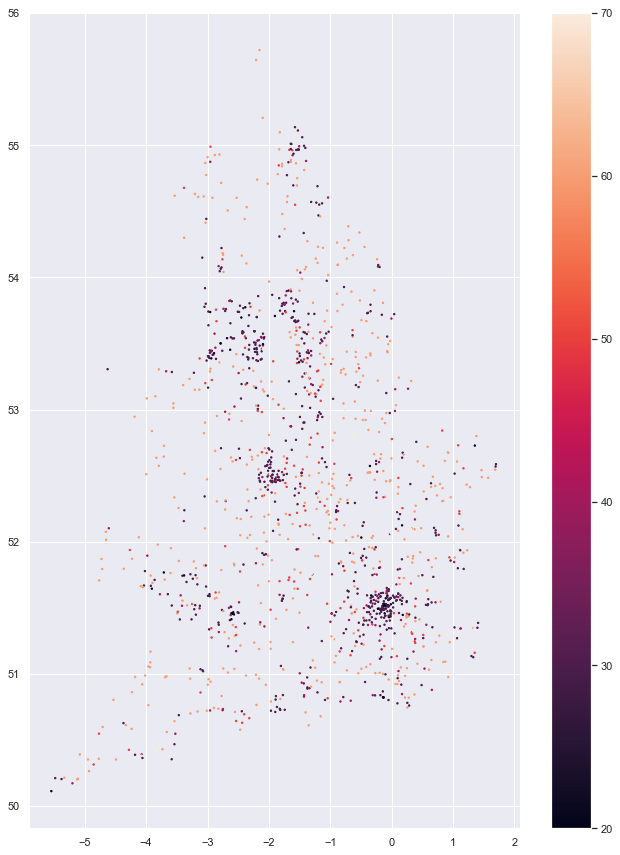

In [10]:
fig = plt.figure(figsize=(11, 15))

msk_severity = df["Accident_Severity"].isin([1,])

plt.scatter(
    df.Longitude.loc[msk_severity],
    df.Latitude.loc[msk_severity],
    c=df["Speed_limit"].loc[msk_severity],
    s=2,
)
plt.colorbar()

The problem with this plot is that it is essentially a population density plot for the UK.

After playing around there don't seem to be significant differences as to where accidents with fatalities happen. What probably will change will be the cause and who suffer the consequences the drivers or a 3rd party such as a pedestrian or a cyclist.

## Are all acccidents reported?

In [11]:
total_accidents = np.sum(df["Accident_Severity"].isin([1, 2, 3]))

for accident_severity in [(1, 'Fatal.....'), (2, 'Serious...'), (3, 'Slight....')]:
    n_accidents = np.sum(df["Accident_Severity"].isin([accident_severity[0]]))
    
    print(
        "{0}{1}/{2} -> {3}%".format(
        accident_severity[1],
        n_accidents,
        total_accidents,
        str(n_accidents/total_accidents * 100)[:5],
        )
    )

Fatal.....1535/122838 -> 1.249%
Serious...21155/122838 -> 17.22%
Slight....100148/122838 -> 81.52%


## When do accidents happen?

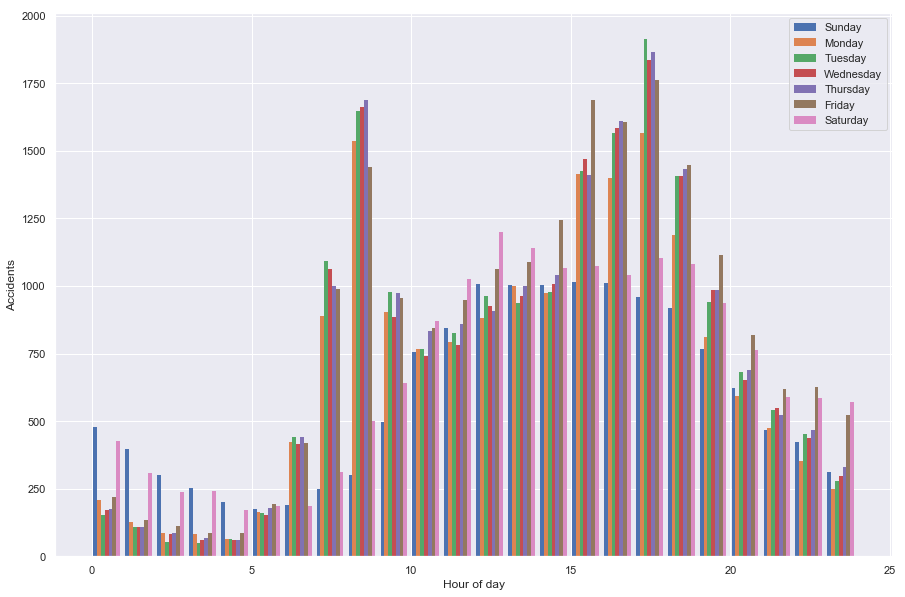

In [39]:
correct_average = False
color_day = ['w', 'k', 'g', 'b', 'y', 'r', 'c']


fig = plt.figure(figsize=(15, 10))

for day in set(df.Day_of_Week):
    msk_day = df.Day_of_Week.isin([day])
    
    avg_corrected_day_accidents = list()
    
    for time in set(df.Time_Hour):
        msk_hour = df.Time_Hour.isin([time])
        if correct_average:
            avg_accidents_per_hour = msk_hour.sum() / 7
        else:
            avg_accidents_per_hour = 0
        
        msk = msk_hour & msk_day
        avg_corrected_day_accidents.append(msk.sum() - avg_accidents_per_hour)
        
        
    plt.bar(
        np.array(range(24))+day*0.12-0.02,
        avg_corrected_day_accidents,
        width=0.12,
        align='center',
        linewidth=0,
        label=str(day),
    )
    
plt.legend()
plt.xlabel("Hour of day")
plt.ylabel("Accidents")

map_idx_to_label = {
    '1': 'Sunday',
    '2': 'Monday',
    '3': 'Tuesday',
    '4': 'Wednesday',
    '5': 'Thursday',
    '6': 'Friday',
    '7': 'Saturday',
}
remap_legend(plt.gca(), map_idx_to_label)

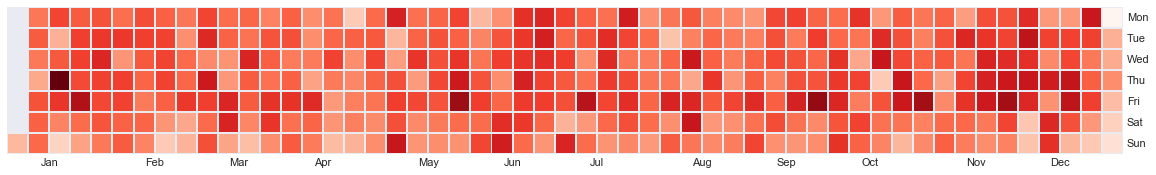

In [13]:
accident_events = df.groupby(["Date"]).count()["Latitude"]

plt.figure(figsize=(20,30))
calmap.yearplot(accident_events, year=2017)

## WRC Hypothesis

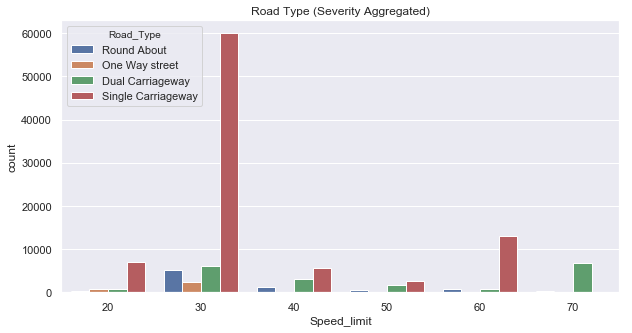

In [14]:
msk = (df["Number_of_Casualties"]<15) & (df["Accident_Severity"].isin([1, 2, 3])) & \
      (df["Road_Type"].isin([1,2,3,6]))

fig, ax = plt.subplots(figsize=(10, 5))    

sns.countplot(
    x="Speed_limit",
    hue="Road_Type",
    data=df.loc[msk],
    ax=ax,
)
ax.set_title("Road Type (Severity Aggregated)", )

map_idx_to_label = {
    '1': 'Round About',
    '2': 'One Way street',
    '3': 'Dual Carriageway',
    '6': 'Single Carriageway',
}
remap_legend(ax, map_idx_to_label)

## England Accidents

Lets check accidents per capita in England. For this we will need the boundary information which we can retrieve from [data.gov.uk](https://data.gov.uk/dataset/0fb911e4-ca3a-4553-9136-c4fb069546f9/ceremonial-county-boundaries-of-england) and the population for each ceremonial county from [wikipedia](https://en.wikipedia.org/wiki/List_of_ceremonial_counties_of_England). We also need a [list of districts](https://en.wikipedia.org/wiki/List_of_English_districts) to match the districts in the dataset to the counties.

The code below is a bit messy as we have first to match district codes to district names on the excel spreadsheet with the metadata. After we have to match districts to counties. As it happens the spellings used by the wikipedia is different than those used in the boundary information. Another complication is that the districts (at least some of them) used by the traffic authority are from before the 1974 changed.

Notes:

1) The wikipedia data has been scrapped with the very convenient web service [wikitable2csv](https://wikitable2csv.ggor.de).

2) I limited myself to ceremonial counties of England as that was the easiest data to collect and use. The territorial sub-division of the UK have a bit of nuance and have changed with time. Also they are different for England, Scotland and Wales. [More information](http://county-wise.org.uk/counties/county-confusion/)

In [16]:
df_guide = pd.read_excel("./Road-Accident-Safety-Data-Guide.xls", sheet_name="Local Authority (District)")

df_district_to_ceremonial = pd.read_csv("./wiki_district_to_ceremonial.csv")
df_district_to_ceremonial = df_district_to_ceremonial.set_index("Name")

df_former_ceremonial = pd.read_csv("./former_ceremonial.csv")
df_former_ceremonial = df_former_ceremonial.set_index("District")

In [17]:
mapCode2Label = {df_guide.iloc[idx]["code"]:df_guide.iloc[idx]["label"] for idx in range(len(df_guide))}
df["District_Name"] = df["Local_Authority_(District)"].map(mapCode2Label)

In [18]:
# Extremely messy code.
# Multiple data sources with to account for the use of pre-1974 counties and districts.

MapDistrict2County = dict()
CountyPopulation = dict()

for district in set(df["District_Name"]):
    try:
        county_df_row = df_district_to_ceremonial.loc[district]
        
        ceremonial_county = county_df_row["Ceremonial County"]
        MapDistrict2County[district] = ceremonial_county
        if ceremonial_county not in CountyPopulation:
            CountyPopulation[ceremonial_county] = int(county_df_row["Population(2017 est.)"].replace(',', ''))

    except KeyError:
        try:
            county_df_row = df_former_ceremonial.loc[district]
            
            ceremonial_county = county_df_row["Successor"]
            MapDistrict2County[district] = ceremonial_county
            if ceremonial_county not in CountyPopulation:
                CountyPopulation[ceremonial_county] = \
                    int((df_district_to_ceremonial.loc[district])["Population(2017 est.)"].replace(',', ''))

        except:
            continue

In [19]:
df["County"] = df["District_Name"].map(MapDistrict2County)

In [20]:
accident_events = df.groupby(["County"]).count()["Latitude"]

In [21]:
CountyAccidentsPerCapita = dict()
for county in accident_events.index:
    try:
        CountyAccidentsPerCapita[county] = accident_events[county] / CountyPopulation[county]
    except KeyError:
        continue

In [22]:
sf = shapefile.Reader('./English_Ceremonial_Counties/English Ceremonial Counties.shp')

county_names = [council.as_dict()["NAME"] for council in sf.iterRecords()]

In [23]:
# We need fuzzy matching here to solve problems when spelling between
# the names on the shapefile records and those from wikipedia and
# the police don't match.

from fuzzywuzzy import process

county_accidents = dict()

for shape in sf.iterRecords():
    county_name = shape.as_dict()["NAME"]
    try:
        accident_density = CountyAccidentsPerCapita[county_name]
        county_accidents[county_name] = accident_density
    except KeyError:
        # If can't find the key go for closest match
        fuzzy_match = process.extract(county_name, CountyAccidentsPerCapita.keys())[0][0]
        accident_density = CountyAccidentsPerCapita[fuzzy_match]
        county_accidents[county_name] = accident_density
        continue

/Users/garfield/Library/Python/3.5/lib/python/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


We now have the data and can go onto doing the plotting.

In [32]:
min_density = np.min([CountyAccidentsPerCapita[county] for county in CountyAccidentsPerCapita])
max_density = np.max([CountyAccidentsPerCapita[county] for county in CountyAccidentsPerCapita])

cmap = mpl.cm.copper
norm = mpl.colors.Normalize(vmin=min_density, vmax=max_density)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

county_color = {k:mapper.to_rgba(county_accidents[k]) for k in county_names}

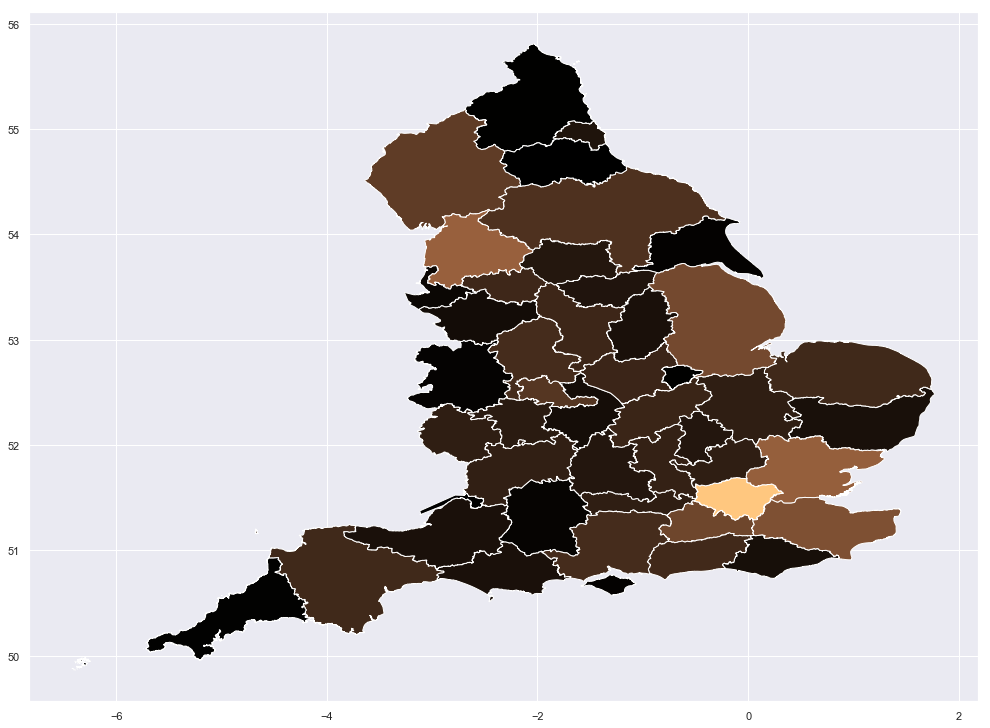

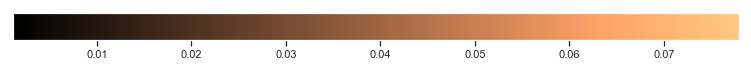

In [33]:
def plot_council(ax, sf, colors=None):
    for shape in sf.iterShapeRecords():
        npoints=len(shape.shape.points) # total points
        nparts = len(shape.shape.parts) # total parts
        
        name = shape.record.as_dict()["NAME"]
        
        if colors is None:
            color = [0.5,0.5,0.5]
        else:
            color = colors[name]

        if nparts == 1:
            polygon = Polygon(shape.shape.points)
            patch = PolygonPatch(polygon, facecolor=color)
            ax.add_patch(patch)

        else:
            for ip in range(nparts):
                i0=shape.shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.shape.parts[ip+1]-1
                else:
                    i1 = len(shape.shape.points)

                polygon = Polygon(shape.shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=color)
                ax.add_patch(patch)
    # Some bug in my libraries. If I don't do a call to plot nothing shows up??
    plt.plot([1],[50])

plt.figure(figsize=(17, 14))
ax = plt.axes()
ax.set_aspect('equal')
# ax.set_title("Accidents Per Capita (England)")

plot_council(ax, sf, county_color)
plt.show()

# Add a colorbar on a plot below
fig, ax = plt.subplots(figsize=(13, 1))
fig.subplots_adjust(bottom=0.5)
cb1 = mpl.colorbar.ColorbarBase(
    ax, cmap=cmap, norm=norm, orientation='horizontal')